# 02_SIMBA_spatial

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype
import pandas as pd
import numpy as np

In [3]:
import plotly.express as px

In [4]:
import os
import simba as si
si.__version__

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_si

'1.2'

In [5]:
workdir = 'result_simba_spatial'
si.settings.set_workdir(workdir)

Saving results in: result_simba_spatial


In [6]:
si.settings.set_figure_params(
    dpi=80,
    style='white',
    fig_size=[5,5],
    rc={'image.cmap': 'viridis'}
)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

# Data

In [7]:
h5_fn = "./result_simba_rnaseq_spatialLIBD/data/151673.h5ad"
adata_CG = sc.read_h5ad(h5_fn)
adata_CG

AnnData object with n_obs × n_vars = 3611 × 16578
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# Preparing a spatial graph

## Neighborhood

0 if neighbor, 1 if not. Includes diagnoals 

In [8]:
tmp_obs = adata_CG.obs.copy()
tmp_obs.index.name = 'barcode'
tmp_obs = tmp_obs.reset_index().set_index(['array_row', 'array_col']).sort_index()

In [9]:
spatial_adj_df = pd.DataFrame(index=adata_CG.obs.index, columns = adata_CG.obs.index, dtype=np.float32).fillna(0.0)

In [10]:
radius = 5
for barcode, r in adata_CG.obs.iterrows():
    row, col = r['array_row'], r['array_col']

    neighbors = adata_CG.obs[
        adata_CG.obs['array_row'].between(row - radius, row + radius) & 
        adata_CG.obs['array_col'].between(col - radius, col + radius)
    ].index
    spatial_adj_df.loc[barcode, neighbors] = 1.0


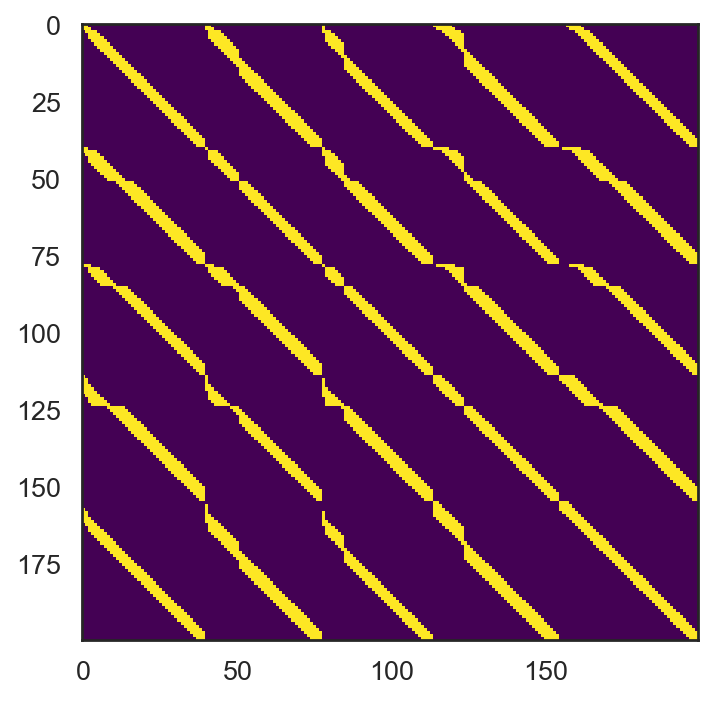

In [11]:
sorted_barcodes = adata_CG.obs.sort_values(by=['array_row', 'array_col']).index
plt.imshow(spatial_adj_df.loc[sorted_barcodes, sorted_barcodes].iloc[:200, :200])

Missing data/spots

In [12]:
import anndata as ad
from scipy.sparse import csr_matrix

In [59]:
spatial_adj_matrix = csr_matrix(spatial_adj_df, dtype=np.float32)
adata_N = ad.AnnData(spatial_adj_matrix)
adata_N

AnnData object with n_obs × n_vars = 3611 × 3611

In [92]:
adata_N.layers['simba'] = adata_N.X

In [93]:
adata_N

AnnData object with n_obs × n_vars = 3611 × 3611
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden', 'pbg_id'
    var: 'pbg_id'
    layers: 'simba'

In [60]:
adata_N.obs.index = spatial_adj_df.index
adata_N.var.index = spatial_adj_df.index

In [61]:
adata_N.obs = adata_CG.obs.copy()
adata_N.var.index = adata_CG.obs.index

In [65]:
adata_N

AnnData object with n_obs × n_vars = 3611 × 3611
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden'

## Generate graph

In [66]:
si.tl.gen_graph(
    list_adata=[adata_N],
    prefix='N',
    # layer='simba',
    use_highly_variable=False, 
    dirname='graph0'
)

`simba` does not exist in adata 0 in `list_adata`.`.X` is being used instead.
relation0: source: N0, destination: N0
#edges: 204531
Total number of edges: 204531
Writing graph file "pbg_graph.txt" to "result_simba_spatial/pbg/graph0" ...


/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/simba/tools/_pbg.py:307: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Finished.


## Train

In [67]:
si.settings.pbg_params

{'entity_path': 'result_simba_spatial/pbg/graph0/input/entity',
 'edge_paths': ['result_simba_spatial/pbg/graph0/input/edge'],
 'checkpoint_path': 'result_simba_spatial/pbg/graph0/model',
 'entities': {'N0': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'N0',
   'rhs': 'N0',
   'operator': 'none',
   'weight': 1.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping': False,
 'regularization_coef': 0.0,
 'wd': 0.173251,
 'wd_interval': 50,
 'eval_fraction': 0.05,
 'eval_num_batch_negs': 50,
 'eval_num_uniform_negs': 50,
 'checkpoint_preservation_interval': None}

In [68]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.173251
Weight decay being used for training is 0.173251
Converting input data ...
[2025-01-08 21:13:32.219445] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2025-01-08 21:13:32.219943] These files are in: result_simba_spatial/pbg/graph0/input/entity, result_simba_spatial/pbg/graph0/input/edge
Starting training ...
Finished


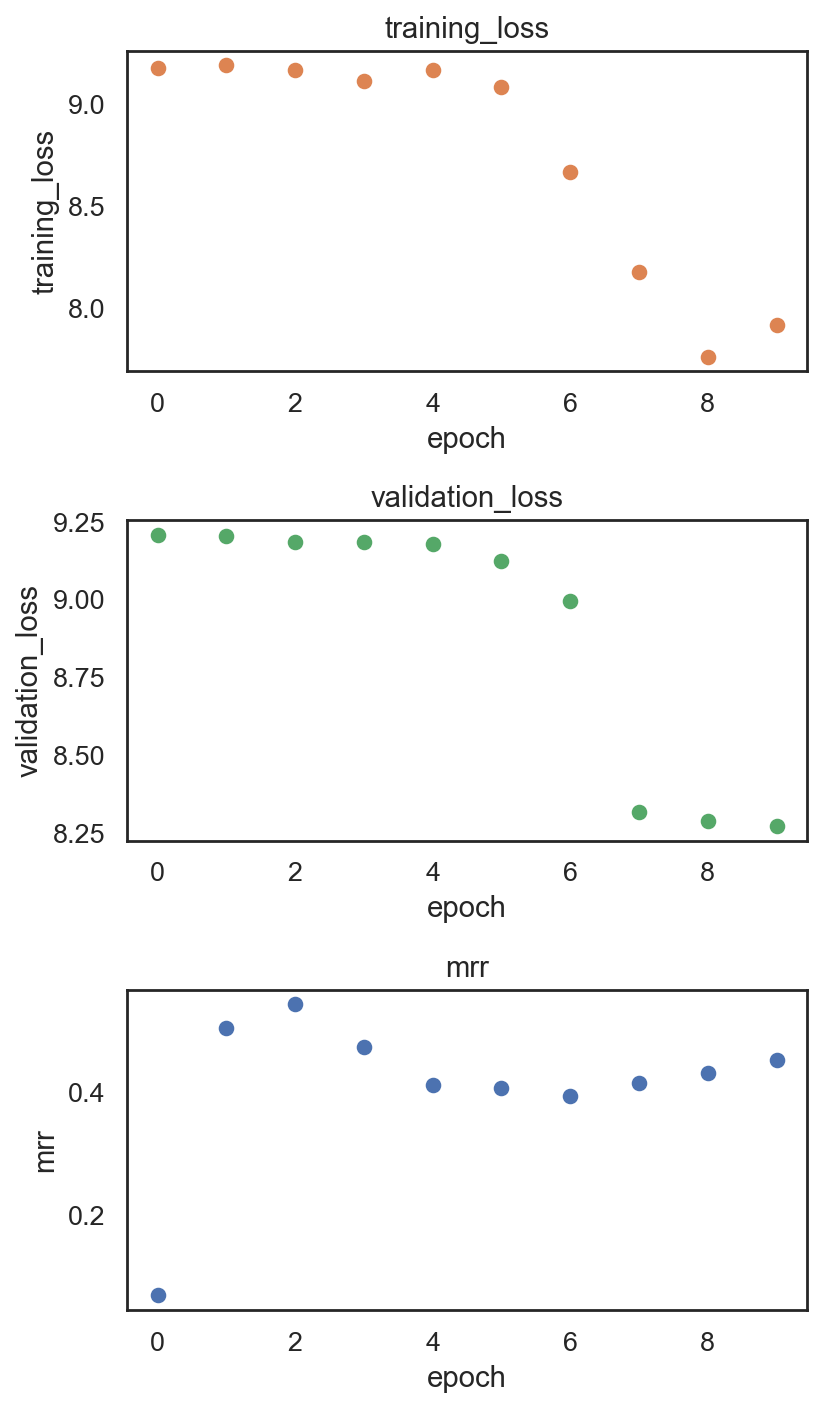

In [69]:
si.pl.pbg_metrics(fig_ncol=1)

Set seed. Unpredictable training

## Post embedding

In [70]:
# read in entity embeddings obtained from pbg training.
dict_adata = si.read_embedding()
dict_adata

{'N0': AnnData object with n_obs × n_vars = 3611 × 50}

In [71]:
dict_adata

{'N0': AnnData object with n_obs × n_vars = 3611 × 50}

In [72]:
adata_N0 = dict_adata['N0']  # embeddings of cells

In [73]:
adata_N0

AnnData object with n_obs × n_vars = 3611 × 50

In [74]:
adata_N0.obs['spatialLIBD'] = adata_CG[adata_N0.obs_names,:].obs['spatialLIBD'].copy()
adata_N0

AnnData object with n_obs × n_vars = 3611 × 50
    obs: 'spatialLIBD'

In [86]:
adata_N0.var.index = adata_N0.obs.index

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



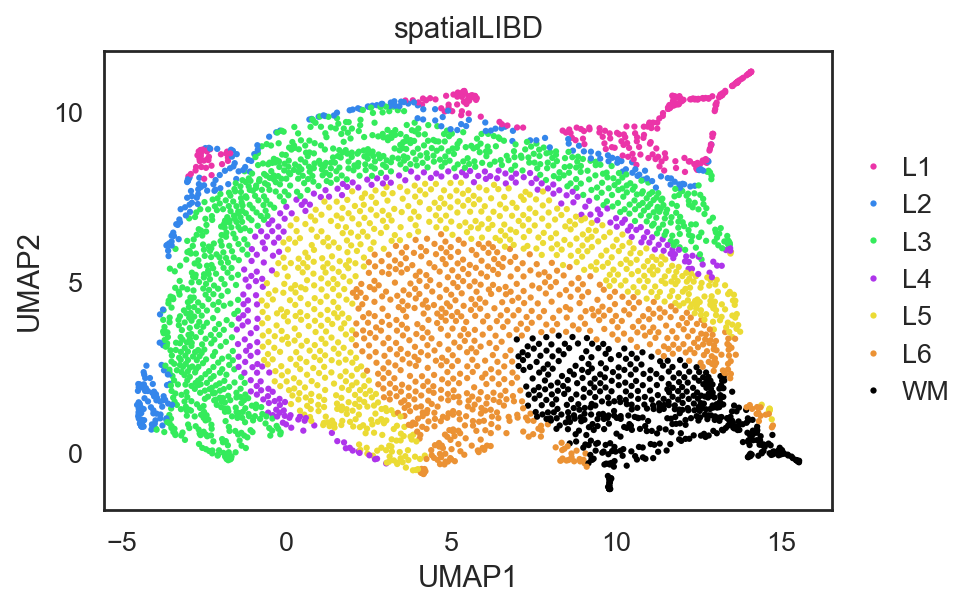

In [75]:
si.tl.umap(adata_N0,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_N0,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [76]:
si.preprocessing.pca(adata_N0)

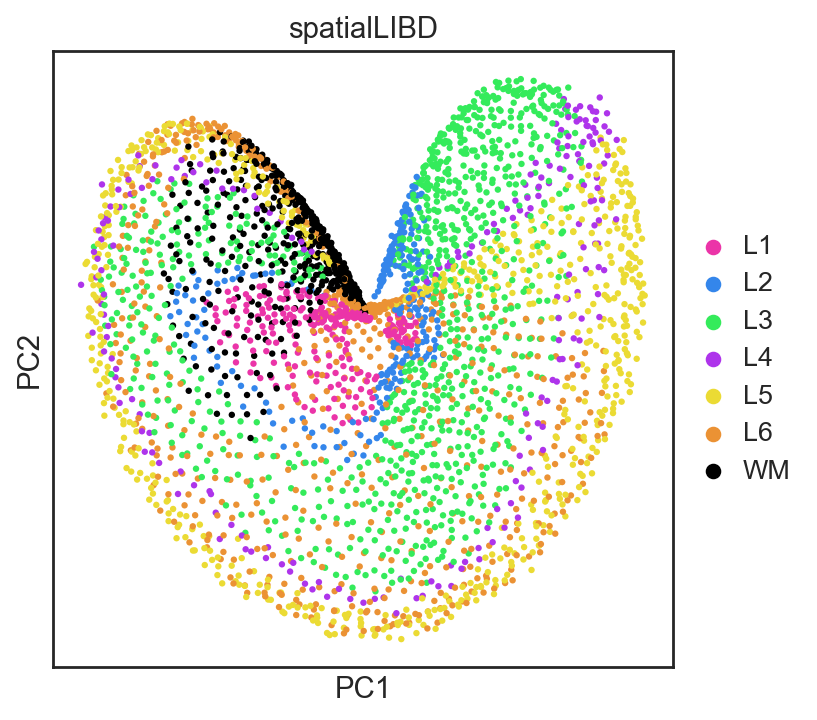

In [77]:
sc.pl.pca(adata_N0, color=['spatialLIBD'], palette=palette_celltype, dimensions=(0, 1))

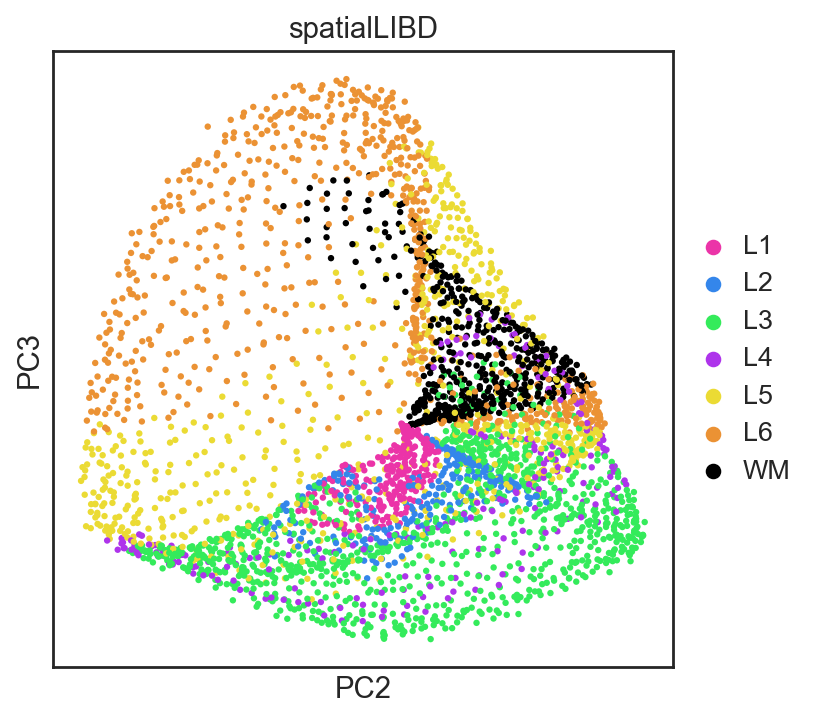

In [78]:
sc.pl.pca(adata_N0, color=['spatialLIBD'], palette=palette_celltype, dimensions=(1, 2))

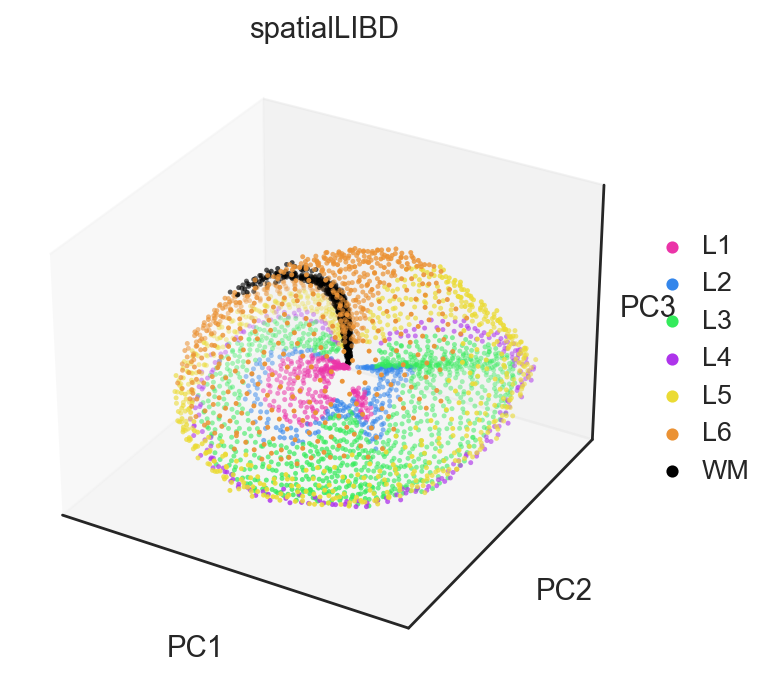

In [79]:
sc.pl.pca(adata_N0, color=['spatialLIBD'], palette=palette_celltype, projection='3d')

In [80]:
fig = px.scatter_3d(
    x=adata_N0.obsm['X_pca'][:, 0], 
    y=adata_N0.obsm['X_pca'][:, 1], 
    z=adata_N0.obsm['X_pca'][:, 2],
    color = adata_N0.obs['spatialLIBD'],
    width=500, height=500,
    color_discrete_map=palette_celltype,
)
fig.update_layout(#plot_bgcolor='rgb(12,163,135)',
                  #paper_bgcolor='rgb(12,163,135)'
                  #coloraxis={"colorbar": {"x": -0.2, "len": 0.5, "y": 0.8}}, #I think this is for contours
                 scene = dict(
                                xaxis = dict(
                                     backgroundcolor="rgba(0, 0, 0,0)",
                                     gridcolor="white",
                                     showbackground=True,
                                     zerolinecolor="white",),
                                yaxis = dict(
                                    backgroundcolor="rgba(0, 0, 0,0)",
                                    gridcolor="white",
                                    showbackground=True,
                                    zerolinecolor="white"),
                                zaxis = dict(
                                    backgroundcolor="rgba(0, 0, 0,0)",
                                    gridcolor="white",
                                    showbackground=True,
                                    zerolinecolor="white",),),
                 )
fig.update_traces(marker=dict(size=2))
fig.show()

# RNAseq

## Discretize

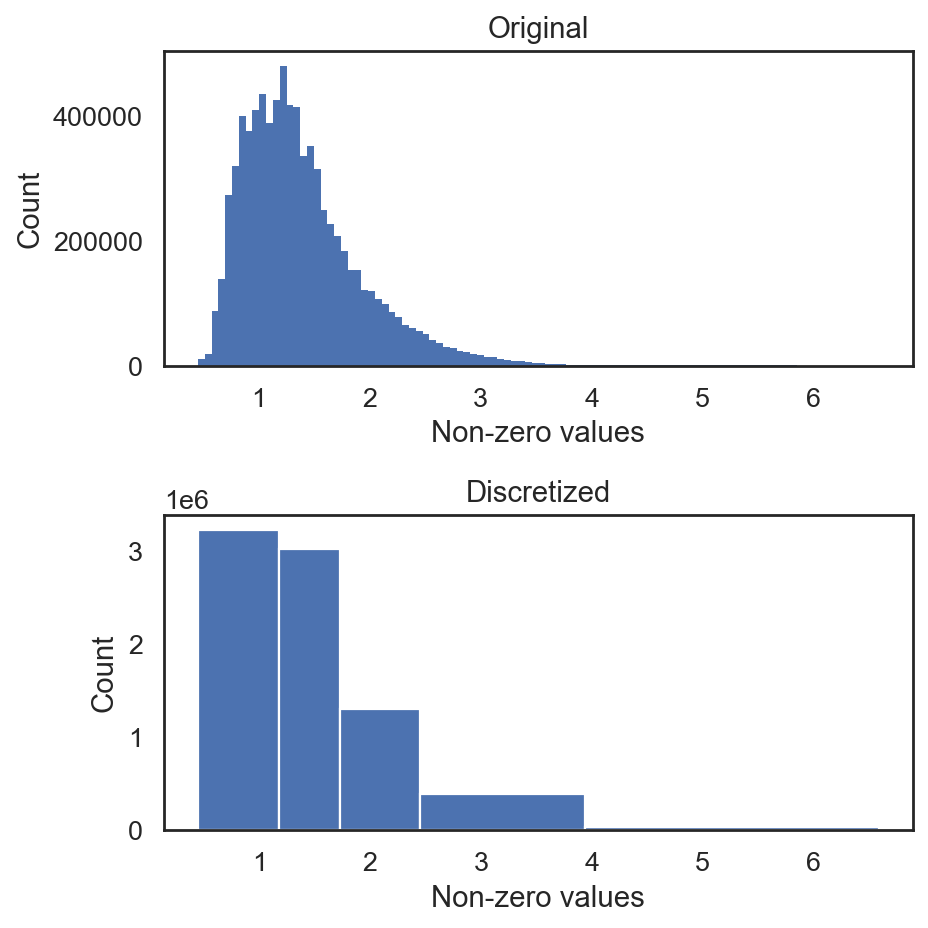

In [81]:
si.tl.discretize(adata_CG,n_bins=5)
si.pl.discretize(adata_CG,kde=False)

# CC and CG graph

In [94]:
si.tl.gen_graph(
    list_CG=[adata_CG],
    list_CC=[adata_N],
    layer='simba',
    use_highly_variable=False, 
    dirname='graph_SCG'# spatial cell gene
)

relation0: source: C, destination: G
#edges: 3219964
relation1: source: C, destination: G
#edges: 3011006
relation2: source: C, destination: G
#edges: 1298252
relation3: source: C, destination: G
#edges: 390354
relation4: source: C, destination: G
#edges: 36477
relation5: source: C, destination: C
#edges: 204531
Total number of edges: 8160584
Writing graph file "pbg_graph.txt" to "result_simba_spatial/pbg/graph_SCG" ...
Finished.


In [88]:
adata_N

AnnData object with n_obs × n_vars = 3611 × 3611
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden', 'pbg_id'
    var: 'pbg_id'

In [95]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.004342
Weight decay being used for training is 0.004342
Converting input data ...
[2025-01-08 21:17:09.502096] Using the 6 relation types given in the config
[2025-01-08 21:17:09.502559] Searching for the entities in the edge files...
[2025-01-08 21:17:16.402323] Entity type N0:
[2025-01-08 21:17:16.403105] - Found 0 entities
[2025-01-08 21:17:16.403620] - Removing the ones with fewer than 1 occurrences...
[2025-01-08 21:17:16.404201] - Left with 0 entities
[2025-01-08 21:17:16.404898] - Shuffling them...
[2025-01-08 21:17:16.405450] Entity type C:
[2025-01-08 21:17:16.405856] - Found 3611 entities
[2025-01-08 21:17:16.406282] - Removing the ones with fewer than 1 occurrences...
[2025-01-08 21:17:16.407508] - Left with 3611 entities
[2025-01-08 21:17:16.407974] - Shuffling them...
[2025-01-08 21:17:16.409641] Entity type G:
[2025-01-08 21:17:16.410265] - Found 16578 entities
[2025-01-08 21:17:16.410650]

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: T

Finished


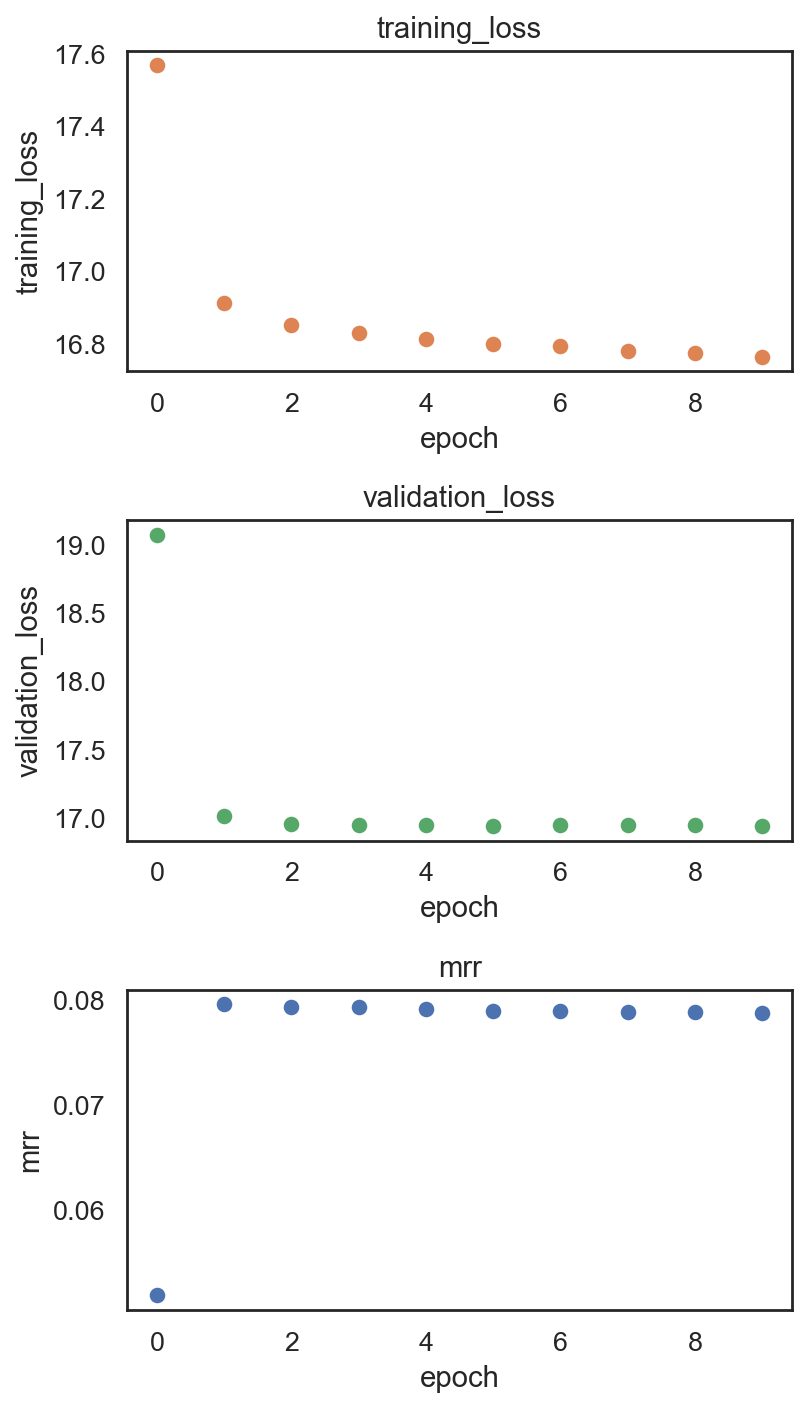

In [96]:
si.pl.pbg_metrics(fig_ncol=1)

# Post training

In [97]:
# read in entity embeddings obtained from pbg training.
dict_adata = si.read_embedding()
dict_adata

{'G': AnnData object with n_obs × n_vars = 16578 × 50,
 'C': AnnData object with n_obs × n_vars = 3611 × 50}

In [98]:
adata_C = dict_adata['C']  # embeddings of cells
adata_G = dict_adata['G']  # embeddings of genes

In [99]:
adata_C.obs['spatialLIBD'] = adata_CG[adata_C.obs_names,:].obs['spatialLIBD'].copy()
adata_C

AnnData object with n_obs × n_vars = 3611 × 50
    obs: 'spatialLIBD'

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



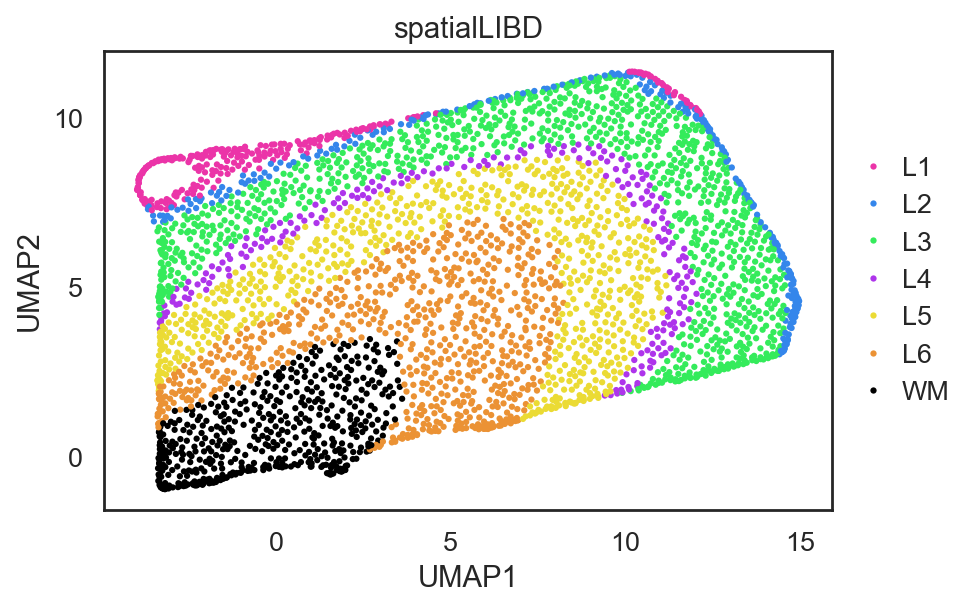

In [100]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [101]:
si.preprocessing.pca(adata_C)

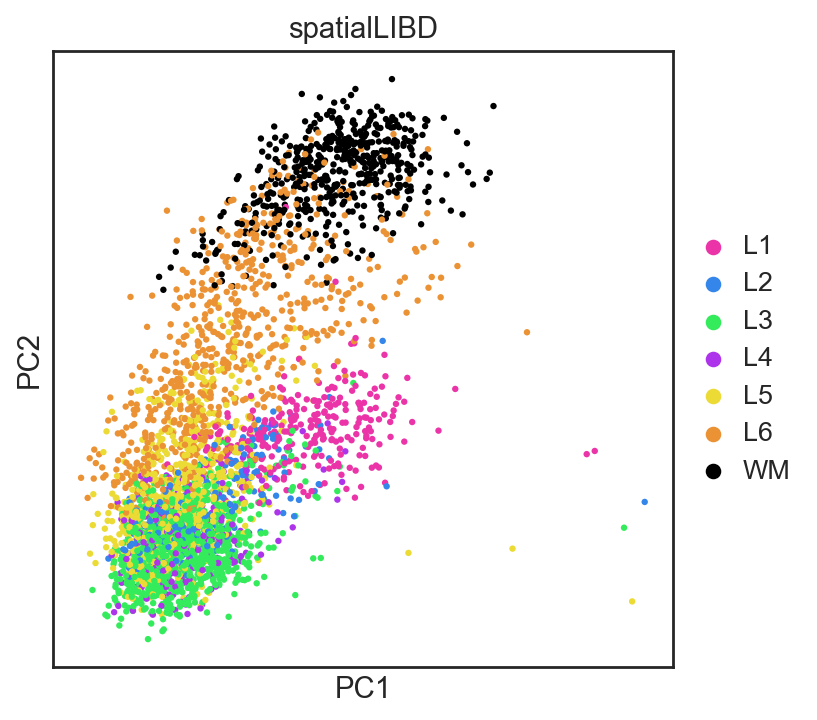

In [102]:
sc.pl.pca(adata_C, color=['spatialLIBD'], palette=palette_celltype, dimensions=(0, 1))

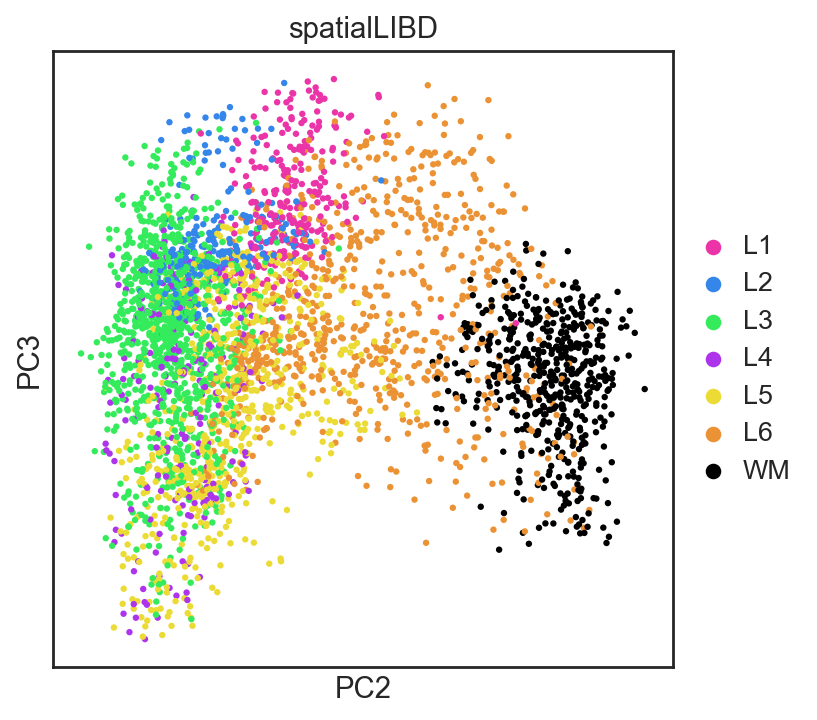

In [103]:
sc.pl.pca(adata_C, color=['spatialLIBD'], palette=palette_celltype, dimensions=(1, 2))

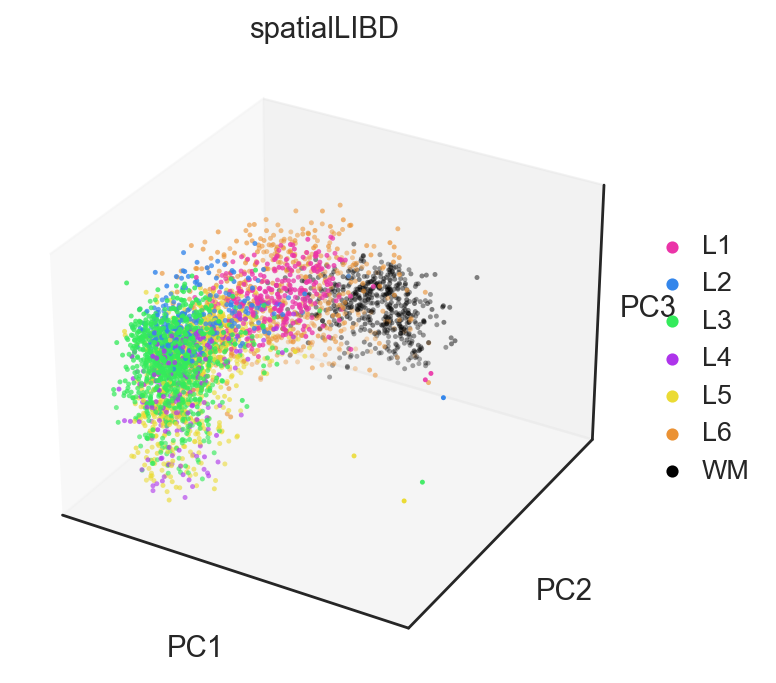

In [104]:
sc.pl.pca(adata_C, color=['spatialLIBD'], palette=palette_celltype, projection='3d')

# joint embedding

In [111]:
adata_C.X.shape

(3611, 50)

In [105]:
# embed cells and genes into the same space
adata_all = si.tl.embed(adata_ref=adata_C,list_adata_query=[adata_G])
adata_all.obs.head()

Performing softmax transformation for query data 0;


,spatialLIBD,id_dataset
ACGTATTACTCCGATC-1,L3,ref
CCCGCGCAATGCACCC-1,L3,ref
GGGCGTGGTTTCCCAG-1,L5,ref
TCGTTGGCTCGTCAAT-1,L1,ref
GGCGAGCGAAACGGCA-1,L6,ref


In [106]:
## add annotations of cells and genes
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'spatialLIBD']
adata_all.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'
adata_all.obs.head()

,spatialLIBD,id_dataset,entity_anno
ACGTATTACTCCGATC-1,L3,ref,L3
CCCGCGCAATGCACCC-1,L3,ref,L3
GGGCGTGGTTTCCCAG-1,L5,ref,L5
TCGTTGGCTCGTCAAT-1,L1,ref,L1
GGCGAGCGAAACGGCA-1,L6,ref,L6


In [107]:
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/simba/plotting/_plot.py:1065: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



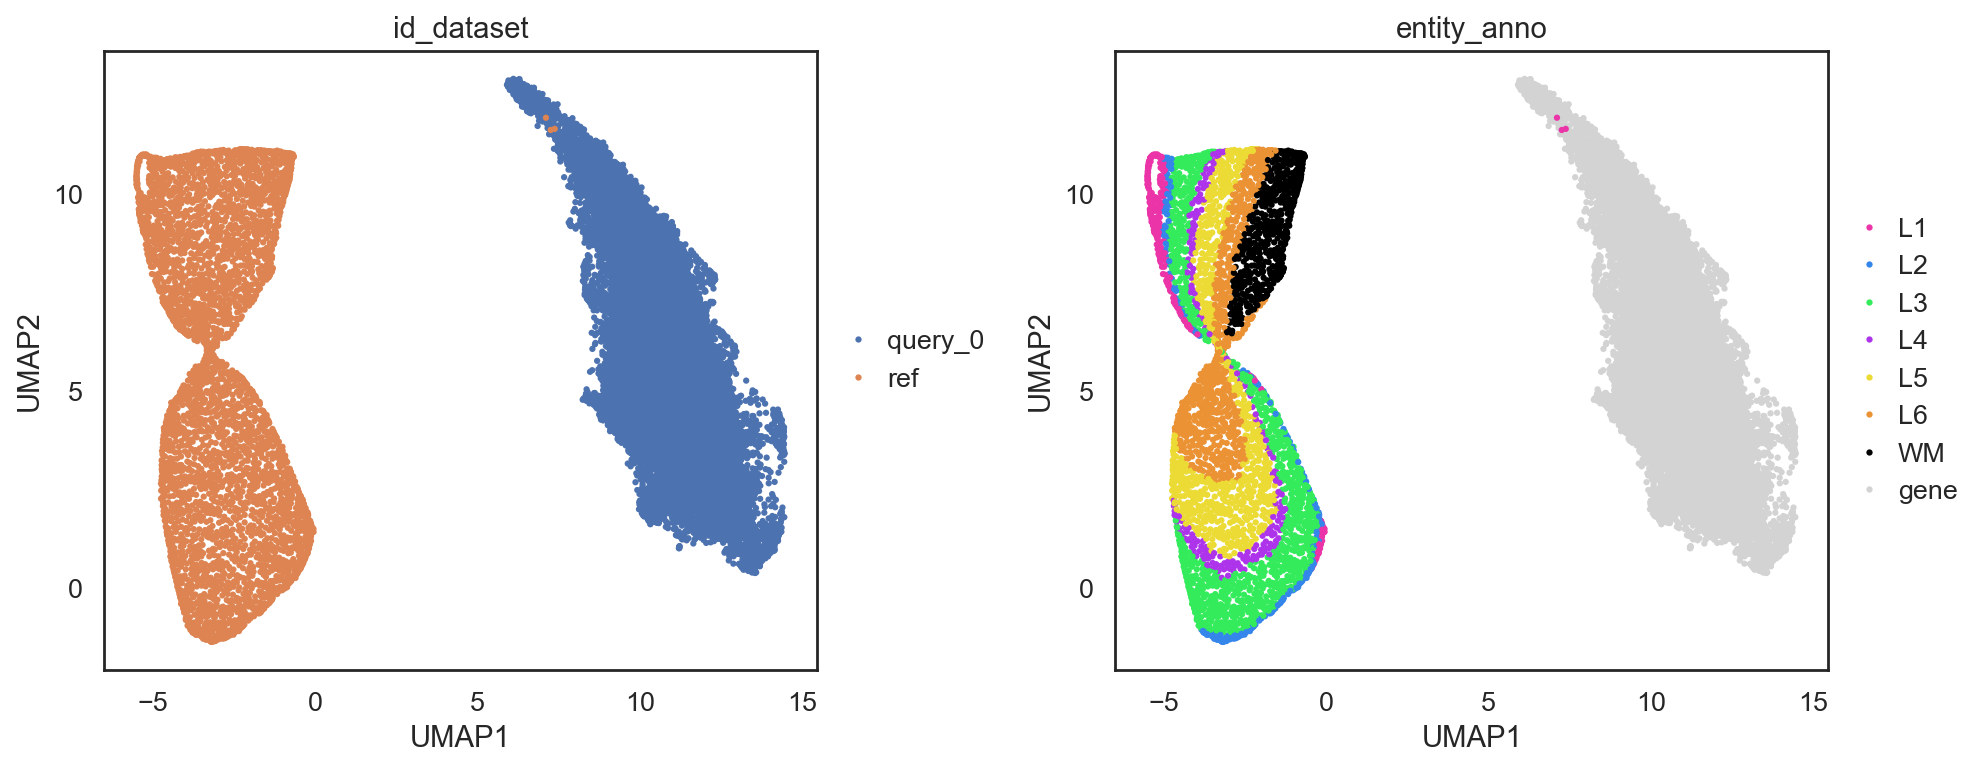

In [108]:
si.tl.umap(adata_all,n_neighbors=15,n_components=2)
si.pl.umap(adata_all[::-1,],color=['id_dataset','entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(6,5))

I used a weight of 1 for neighboring cells to add the edges. Would it matter if I used a smaller weight?